# ***Libraries***

In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
import numpy as np

# Selection
View (iteratively and manually) some datasets and select two time series from four dataset.

In [21]:
import os

def get_all_file_paths(directory):
    """
    Get full paths of all files in a directory.
    
    Parameters:
    directory (str): The path of the directory.
    
    Returns:
    list: A list of full file paths.
    """
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            full_path = os.path.join(root, file)
            file_paths.append(full_path)
    return file_paths

# Define a function that opens and reads the dataset and returns its parts (timeseries and labels)
def unpack_series(series_location):
    df = pd.read_csv(series_location, header=None).to_numpy()
    data = df[:, 0].astype(float)
    label = df[:, 1]

    return {
        'Name': series_location,
        'data': data,
        'labels': label
    }

from tqdm import tqdm

def plot_time_series_subplots(time_series):

    normality = list(time_series[0]['Name']).count('+') + 1
    fig, ax_lines = plt.subplots(len(time_series), 2, figsize=(10, len(time_series) * 5))

    # Force axes returned to be a list, even when one timeseries is given.
    if len(time_series) == 1:
        ax_lines = [ax_lines]

    for idx, full_details in enumerate(tqdm(time_series)):
        name = full_details['Name']
        time_series = full_details['data']
        labels = full_details['labels']

        axs = ax_lines[idx]
        full = axs[0]
        cutoff = axs[1]
        full.plot(time_series, c = 'blue')

        # Plot subseries that are anomalous.
        reds = []
        red_begin = -1
        red_end = -1
        for i in range(len(time_series) - 1):
            if labels[i] == 1 and red_begin == -1:
                red_begin = i
                red_end = i
            elif labels[i] == 1 and red_begin != -1:
                red_end += 1
            elif labels[i] == 0 and red_begin != -1:
                reds.append((red_begin, red_end))
                red_begin = -1
                red_end = -1
        # Handle case where outlier is at the end of the series.
        if labels[i] == 1 and red_begin == -1:
            red_begin = i
            red_end = i
        elif labels[i] == 1 and red_begin != -1:
            red_end += 1
        elif labels[i] == 0 and red_begin != -1:
            reds.append((red_begin, red_end))
            red_begin = -1
            red_end = -1

        for redb, rede in reds:
            
            full.axvspan(redb, rede, alpha=0.5, color='red')

            # axs[idx].plot([redb, rede], [time_series[redb], time_series[rede]], c = 'red')
        
        full.set_title(f"Series Name: {name}\nNormality: {normality}\nTotal Abnormalities: {np.sum(labels)}\nAbnormalities%: {np.sum(labels)/time_series.shape[0]}")
        full.set_xlabel('Time')
        full.set_ylabel('Value')
        full.grid(True)

        time_series = full_details['data'][:20_000]
        labels = full_details['labels'][:20_000]

        cutoff.plot(time_series, c = 'blue')

        # Plot subseries that are anomalous.
        reds = []
        red_begin = -1
        red_end = -1
        for i in range(len(time_series) - 1):
            if labels[i] == 1 and red_begin == -1:
                red_begin = i
                red_end = i
            elif labels[i] == 1 and red_begin != -1:
                red_end += 1
            elif labels[i] == 0 and red_begin != -1:
                reds.append((red_begin, red_end))
                red_begin = -1
                red_end = -1
        # Handle case where outlier is at the end of the series.
        if labels[i] == 1 and red_begin == -1:
            red_begin = i
            red_end = i
        elif labels[i] == 1 and red_begin != -1:
            red_end += 1
        elif labels[i] == 0 and red_begin != -1:
            reds.append((red_begin, red_end))
            red_begin = -1
            red_end = -1

        for redb, rede in reds:
            
            cutoff.axvspan(redb, rede, alpha=0.5, color='red')

            # axs[idx].plot([redb, rede], [time_series[redb], time_series[rede]], c = 'red')
        
        cutoff.set_title(f"Series Name: {name}\nNormality: {normality}\nTotal Abnormalities: {np.sum(labels)}\nAbnormalities%: {(np.sum(labels)+1)/time_series.shape[0]}")
        cutoff.set_xlabel('Time')
        cutoff.set_ylabel('Value')
        cutoff.grid(True)

    plt.tight_layout()
    plt.show()

100%|██████████| 10/10 [00:00<00:00, 43.44it/s]


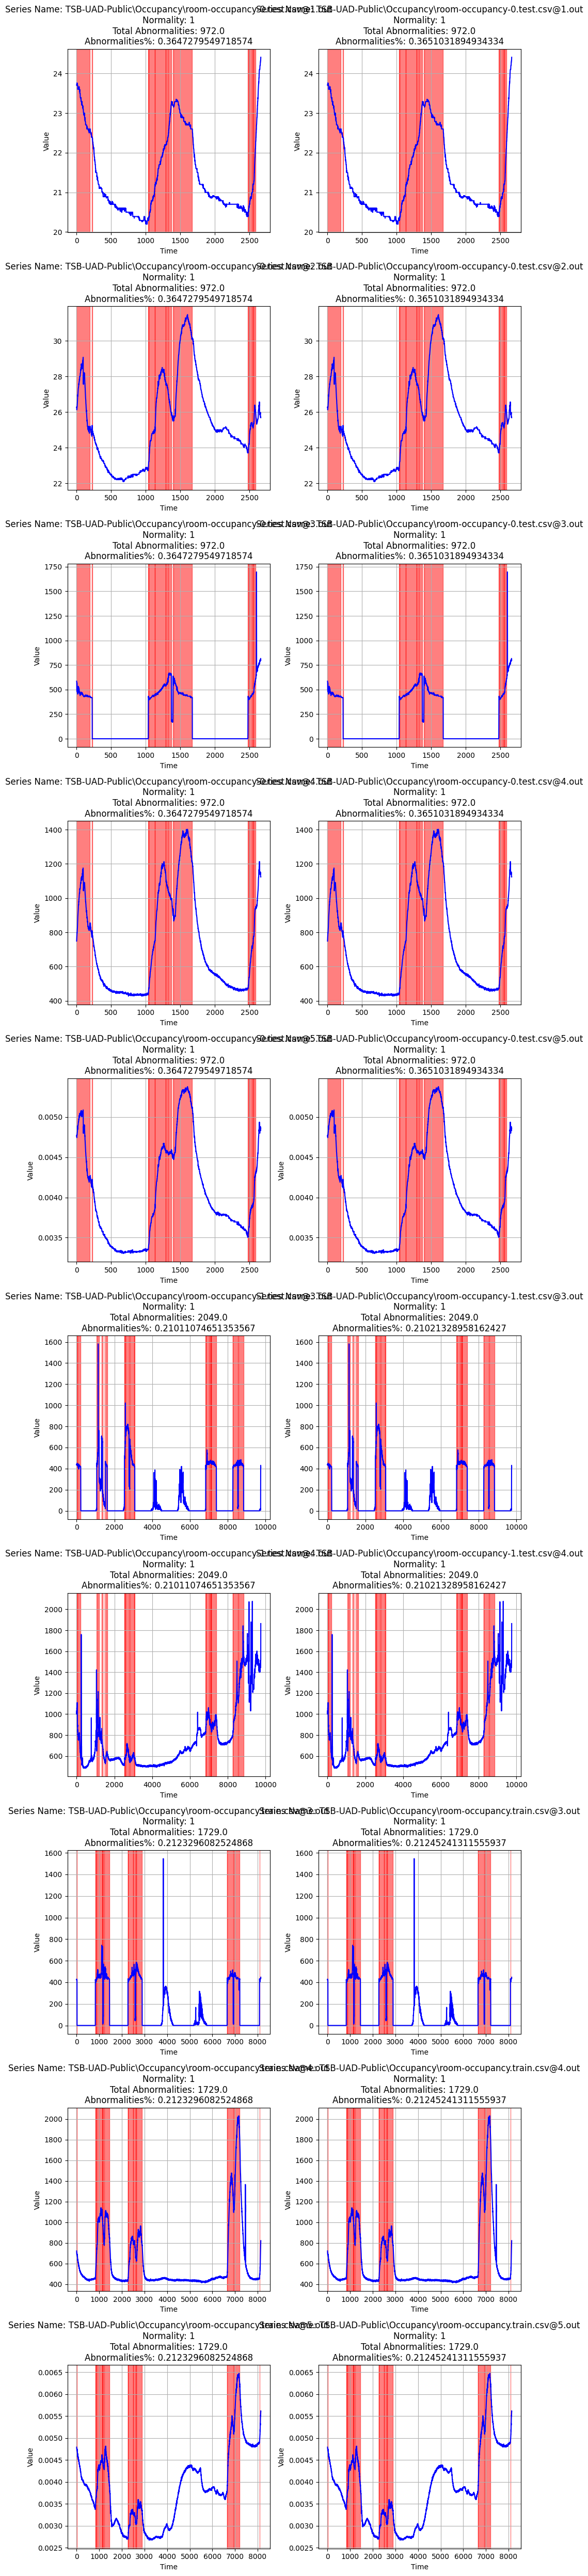

In [23]:
tss = [unpack_series(sl) for sl in list(sorted(get_all_file_paths('TSB-UAD-Public\Occupancy')))[:20]]

plot_time_series_subplots(tss)

# ***Time-Series Selection***

Two time series were selected from four datasets. These were later joined together to form multiple normalities. 

* ECG:
  * MBA_ECG14046_data_0
  * MBA_ECG14046_data_1
* IOPS:
  * KPI-0efb375b-b902-3661-ab23-9a0bb799f4e3.train
  * KPI-0efb375b-b902-3661-ab23-9a0bb799f4e3.test
* SMD:
  * machine-1-1.test.csv@12
  * machine-1-1.test.csv@14
* Occupancy:
  * room-occupancy-0.test.csv@1
  * room-occupancy-0.test.csv@2

The time series selected, were used essentially to form two similar datasets, one to be used for the evaluation of outlier detection methods and another to be used for tuning each method before evaluation without being explicitly biased.


**Evaluation Sets**:
* Single Normality:
  * ECG/MBA_ECG14046_data_0.out titled ECG1
    * Also, the first 20 000 values of the series is added as an independent time series titled ECG1_20k
  * IOPS/KPI-301c70d8-1630-35ac-8f96-bc1b6f4359ea.test titled IOPS1
  * SMD/machine-1-1.test.csv@12 titled SMD1
  * Occupancy/room-occupancy-0.test.csv@1 titled Occupancy1
* Double Normality:
  * ECG1 + IOPS1
  * SMD1 + Occupancy1
* Triple Normality:
  * ECG1 + IOPS1 + Occupancy1
  * SMD1 + ECG1 + Occupancy1
* Quadruple Normality:
  * ECG1 + IOPS1 + SMD1 + Occupancy1

**Tuning Sets**:
* Single Normality:
  * ECG/MBA_ECG14046_data_1 titled ECG2
    * Also, the first 20 000 values of the series is added as an independent time series titled ECG2_20k
  * IOPS/KPI-301c70d8-1630-35ac-8f96-bc1b6f4359ea.train titled IOPS2
  * SMD/machine-1-1.test.csv@14 titled SMD2
  * Occupancy/room-occupancy-0.test.csv@2 titled Occupancy2
* Double Normality:
  * ECG2 + IOPS2
  * SMD2 + Occupancy2
* Triple Normality:
  * ECG2 + IOPS2 + Occupancy2
  * SMD2 + ECG2 + Occupancy2
* Quadruple Normality:
  * ECG2 + IOPS2 + SMD2 + Occupancy2

In [35]:
# Define a function that opens and reads the dataset and returns its parts (timeseries and labels)
def unpack_series(series_location):
    df = pd.read_csv(series_location, header=None).to_numpy()
    data = df[:, 0].astype(float)
    label = df[:, 1]

    return data, label

In [36]:
name_to_dataset = {}

# Selecting Single Normality
single_normality_eval = []
single_normality_tune = []

## ECG
data, labels = unpack_series(r'TSB-UAD-Public\ECG\MBA_ECG14046_data_0.out')
name_to_dataset['ECG1'] = {'Name': 'ECG1', 'data': data, 'labels': labels}
single_normality_eval.append(name_to_dataset['ECG1'])
name_to_dataset['ECG1_20k'] = {'Name': 'ECG1_20k', 'data': data[:20_000], 'labels': labels[:20_000]}
single_normality_eval.append(name_to_dataset['ECG1_20k'])

data, labels = unpack_series(r'TSB-UAD-Public\ECG\MBA_ECG14046_data_1.out')
name_to_dataset['ECG2'] = {'Name': 'ECG2', 'data': data, 'labels': labels}
single_normality_tune.append(name_to_dataset['ECG2'])
name_to_dataset['ECG2_20k'] = {'Name': 'ECG2_20k', 'data': data[:20_000], 'labels': labels[:20_000]}
single_normality_tune.append(name_to_dataset['ECG2_20k'])

## IOPS
data, labels = unpack_series(r'TSB-UAD-Public\IOPS\KPI-301c70d8-1630-35ac-8f96-bc1b6f4359ea.test.out')
name_to_dataset['IOPS1'] = {'Name': 'IOPS1', 'data': data, 'labels': labels}
single_normality_eval.append(name_to_dataset['IOPS1'])

data, labels = unpack_series(r'TSB-UAD-Public\IOPS\KPI-301c70d8-1630-35ac-8f96-bc1b6f4359ea.train.out')
name_to_dataset['IOPS2'] = {'Name': 'IOPS2', 'data': data, 'labels': labels}
single_normality_tune.append(name_to_dataset['IOPS2'])

## SMD
data, labels = unpack_series(r'TSB-UAD-Public\SMD\machine-1-1.test.csv@12.out')
name_to_dataset['SMD1'] = {'Name': 'SMD1', 'data': data, 'labels': labels}
single_normality_eval.append(name_to_dataset['SMD1'])

data, labels = unpack_series(r'TSB-UAD-Public\SMD\machine-1-1.test.csv@14.out')
name_to_dataset['SMD2'] = {'Name': 'SMD2', 'data': data, 'labels': labels}
single_normality_tune.append(name_to_dataset['SMD2'])

## Occupancy
data, labels = unpack_series(r'TSB-UAD-Public\Occupancy\room-occupancy-0.test.csv@1.out')
name_to_dataset['Occupancy1'] = {'Name': 'Occupancy1', 'data': data, 'labels': labels}
single_normality_eval.append(name_to_dataset['Occupancy1'])

data, labels = unpack_series(r'TSB-UAD-Public\Occupancy\room-occupancy-0.test.csv@2.out')
name_to_dataset['Occupancy2'] = {'Name': 'Occupancy2', 'data': data, 'labels': labels}
single_normality_tune.append(name_to_dataset['Occupancy2'])

# Creating Double normality
double_normality_eval = []
double_normality_tune = []

## ECG + IOPS
### Retrieve data from the first timeseries
data, labels = name_to_dataset['ECG1']['data'][:20_000], name_to_dataset['ECG1']['labels'][:20_000]
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['IOPS1']['data'])), np.hstack((labels, name_to_dataset['IOPS1']['labels']))
name_to_dataset['ECG1+IOPS1'] = {'Name': 'ECG1+IOPS1', 'data': data, 'labels': labels}
double_normality_eval.append(name_to_dataset['ECG1+IOPS1'])

### Retrieve data from the first timeseries
data, labels = name_to_dataset['ECG2']['data'][:20_000], name_to_dataset['ECG2']['labels'][:20_000]
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['IOPS2']['data'])), np.hstack((labels, name_to_dataset['IOPS2']['labels']))
name_to_dataset['ECG2+IOPS2'] = {'Name': 'ECG2+IOPS2', 'data': data, 'labels': labels}
double_normality_tune.append(name_to_dataset['ECG2+IOPS2'])

## SMD + Occupancy
### Retrieve data from the first timeseries
data, labels = name_to_dataset['SMD1']['data'], name_to_dataset['SMD1']['labels']
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['Occupancy1']['data'])), np.hstack((labels, name_to_dataset['Occupancy1']['labels']))
name_to_dataset['SMD1+Occupancy1'] = {'Name': 'SMD1+Occupancy1', 'data': data, 'labels': labels}
double_normality_eval.append(name_to_dataset['SMD1+Occupancy1'])

### Retrieve data from the first timeseries
data, labels = name_to_dataset['SMD2']['data'], name_to_dataset['SMD2']['labels']
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['Occupancy2']['data'])), np.hstack((labels, name_to_dataset['Occupancy2']['labels']))
name_to_dataset['SMD2+Occupancy2'] = {'Name': 'SMD2+Occupancy2', 'data': data, 'labels': labels}
double_normality_tune.append(name_to_dataset['SMD2+Occupancy2'])

# Creating Triple normality
triple_normality_eval = []
triple_normality_tune = []

## ECG + IOPS + Occupancy
### Retrieve data from the first timeseries
data, labels = name_to_dataset['ECG1']['data'][:20_000], name_to_dataset['ECG1']['labels'][:20_000]
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['IOPS1']['data'])), np.hstack((labels, name_to_dataset['IOPS1']['labels']))
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['Occupancy1']['data'])), np.hstack((labels, name_to_dataset['Occupancy1']['labels']))
name_to_dataset['ECG1+IOPS1+Occupancy1'] = {'Name': 'ECG1+IOPS1+Occupancy1', 'data': data, 'labels': labels}
triple_normality_eval.append(name_to_dataset['ECG1+IOPS1+Occupancy1'])

### Retrieve data from the first timeseries
data, labels = name_to_dataset['ECG2']['data'][:20_000], name_to_dataset['ECG2']['labels'][:20_000]
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['IOPS2']['data'])), np.hstack((labels, name_to_dataset['IOPS2']['labels']))
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['Occupancy2']['data'])), np.hstack((labels, name_to_dataset['Occupancy2']['labels']))
name_to_dataset['ECG2+IOPS2+Occupancy2'] = {'Name': 'ECG2+IOPS2+Occupancy2', 'data': data, 'labels': labels}
triple_normality_tune.append(name_to_dataset['ECG2+IOPS2+Occupancy2'])

## SMD + ECG + Occupancy
### Retrieve data from the first timeseries
data, labels = name_to_dataset['SMD1']['data'], name_to_dataset['SMD1']['labels']
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['ECG1']['data'][:20_000])), np.hstack((labels, name_to_dataset['ECG1']['labels'][:20_000]))
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['Occupancy1']['data'])), np.hstack((labels, name_to_dataset['Occupancy1']['labels']))
name_to_dataset['SMD1+ECG1+Occupancy1'] = {'Name': 'SMD1+ECG1+Occupancy1', 'data': data, 'labels': labels}
triple_normality_eval.append(name_to_dataset['SMD1+ECG1+Occupancy1'])

### Retrieve data from the first timeseries
data, labels = name_to_dataset['SMD2']['data'], name_to_dataset['SMD2']['labels']
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['ECG2']['data'][:20_000])), np.hstack((labels, name_to_dataset['ECG2']['labels'][:20_000]))
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['Occupancy2']['data'])), np.hstack((labels, name_to_dataset['Occupancy2']['labels']))
name_to_dataset['SMD2+ECG2+Occupancy2'] = {'Name': 'SMD2+ECG2+Occupancy2', 'data': data, 'labels': labels}
triple_normality_tune.append(name_to_dataset['SMD2+ECG2+Occupancy2'])

# Creating Quadruple normality
quadruple_normality_eval = []
quadruple_normality_tune = []

# ECG + IOPS + SMD + Occupancy
### Retrieve data from the first timeseries
data, labels = name_to_dataset['ECG1']['data'][:20_000], name_to_dataset['ECG1']['labels'][:20_000]
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['IOPS1']['data'])), np.hstack((labels, name_to_dataset['IOPS1']['labels']))
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['SMD1']['data'])), np.hstack((labels, name_to_dataset['SMD1']['labels']))
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['Occupancy1']['data'])), np.hstack((labels, name_to_dataset['Occupancy1']['labels']))
name_to_dataset['ECG1+IOPS1+SMD1+Occupancy1'] = {'Name': 'ECG1+IOPS1+SMD1+Occupancy1', 'data': data, 'labels': labels}
quadruple_normality_eval.append(name_to_dataset['ECG1+IOPS1+SMD1+Occupancy1'])

### Retrieve data from the first timeseries
data, labels = name_to_dataset['ECG2']['data'][:20_000], name_to_dataset['ECG2']['labels'][:20_000]
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['IOPS2']['data'])), np.hstack((labels, name_to_dataset['IOPS2']['labels']))
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['SMD2']['data'])), np.hstack((labels, name_to_dataset['SMD2']['labels']))
### Extend with the next one
data, labels = np.hstack((data, name_to_dataset['Occupancy2']['data'])), np.hstack((labels, name_to_dataset['Occupancy2']['labels']))
name_to_dataset['ECG2+IOPS2+SMD2+Occupancy2'] = {'Name': 'ECG2+IOPS2+SMD2+Occupancy2', 'data': data, 'labels': labels}
quadruple_normality_tune.append(name_to_dataset['ECG2+IOPS2+SMD2+Occupancy2'])

In [37]:
import pickle as pkl
datasets = {
    'evaluation': {
        'single_normality': single_normality_eval,
        'double_normality': double_normality_eval,
        'triple_normality': triple_normality_eval,
        'quadruple_normality': quadruple_normality_eval,
    }, 
    'tuning': {
        'single_normality': single_normality_tune,
        'double_normality': double_normality_tune,
        'triple_normality': triple_normality_tune,
        'quadruple_normality': quadruple_normality_tune,
    }, 
    'all': name_to_dataset
}

with open('dataset.pkl', 'wb') as f:
    pkl.dump(datasets, f)

# ***Generated TS Plots***,
Let's plot the time-series files to get an idea of what time series were chosen.

In [27]:
from tqdm import tqdm
def plot_time_series_subplots(time_series):

    normality = list(time_series[0]['Name']).count('+') + 1
    fig, axs = plt.subplots(len(time_series), 1, figsize=(10, len(time_series) * 5))

    # Force axes returned to be a list, even when one timeseries is given.
    if len(time_series) == 1:
        axs = [axs]

    for idx, full_details in enumerate(tqdm(time_series)):
        name = full_details['Name']
        time_series = full_details['data']
        labels = full_details['labels']


        axs[idx].plot(time_series, c = 'blue')

        # Plot subseries that are anomalous.
        reds = []
        red_begin = -1
        red_end = -1
        for i in range(len(time_series) - 1):
            if labels[i] == 1 and red_begin == -1:
                red_begin = i
                red_end = i
            elif labels[i] == 1 and red_begin != -1:
                red_end += 1
            elif labels[i] == 0 and red_begin != -1:
                reds.append((red_begin, red_end))
                red_begin = -1
                red_end = -1
        # Handle case where outlier is at the end of the series.
        if labels[i] == 1 and red_begin == -1:
            red_begin = i
            red_end = i
        elif labels[i] == 1 and red_begin != -1:
            red_end += 1
        elif labels[i] == 0 and red_begin != -1:
            reds.append((red_begin, red_end))
            red_begin = -1
            red_end = -1

        for redb, rede in reds:
            
            axs[idx].axvspan(redb, rede, alpha=0.5, color='red')

            # axs[idx].plot([redb, rede], [time_series[redb], time_series[rede]], c = 'red')
        
        axs[idx].set_title(f"Series Name: {name}\nNormality: {normality}\nTotal Abnormalities: {np.sum(labels)}")
        axs[idx].set_xlabel('Time')
        axs[idx].set_ylabel('Value')
        axs[idx].grid(True)

    plt.tight_layout()
    plt.show()

100%|██████████| 4/4 [00:00<00:00, 12.45it/s]


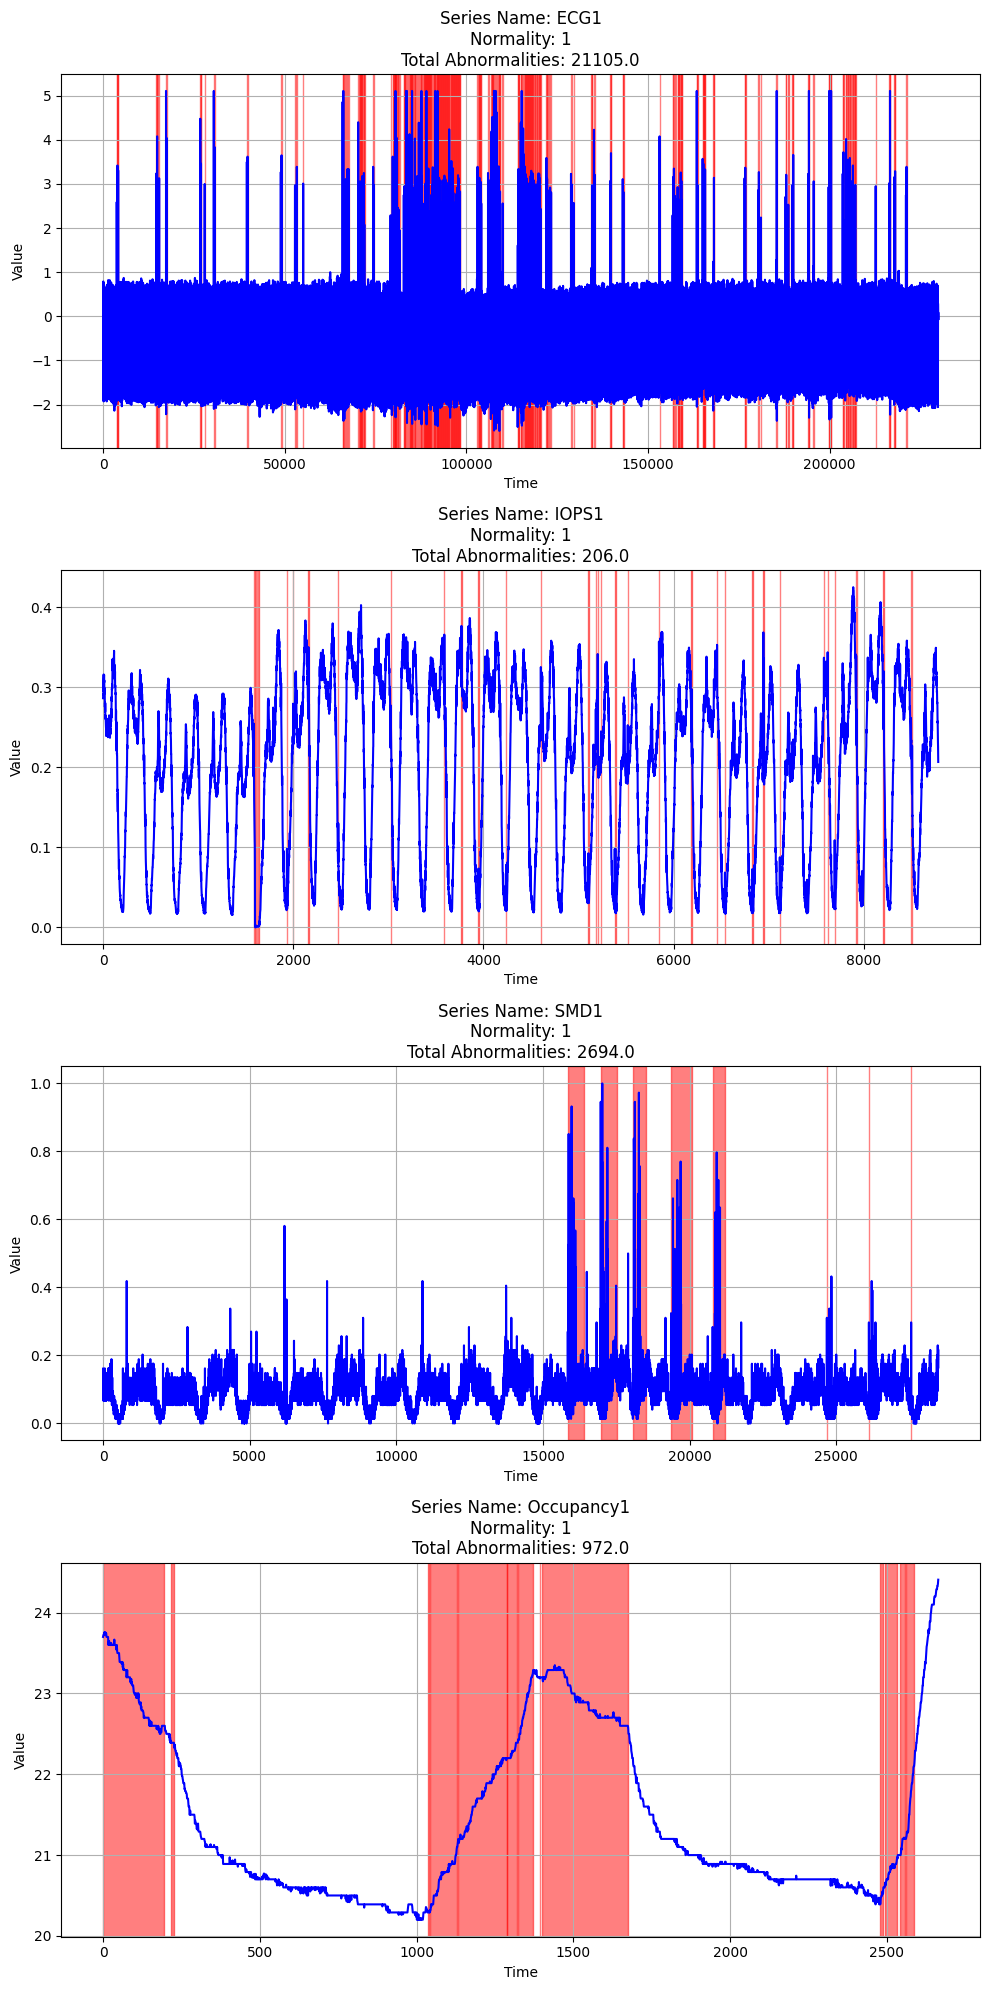

In [28]:
# Call the function to plot the data
plot_time_series_subplots(single_normality_eval)

100%|██████████| 4/4 [00:00<00:00, 10.59it/s]


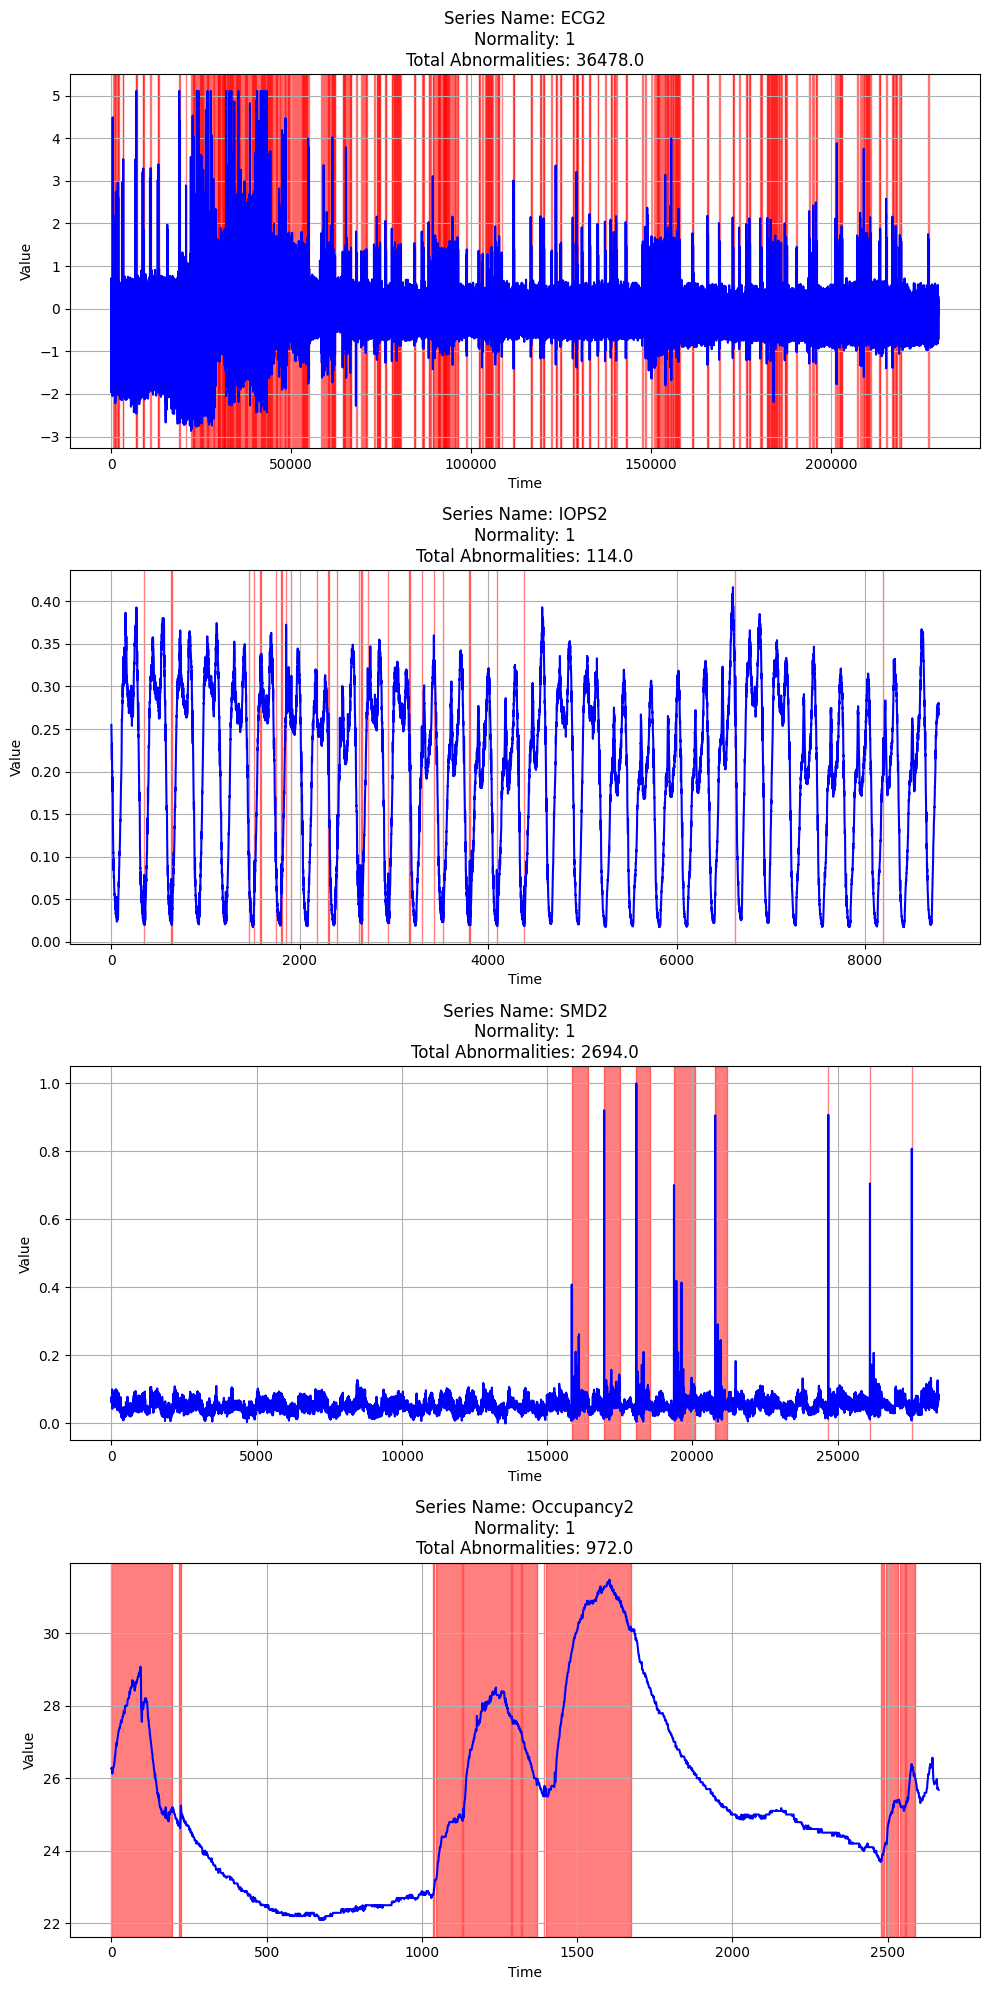

In [29]:
# Call the function to plot the data
plot_time_series_subplots(single_normality_tune)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 27.90it/s]


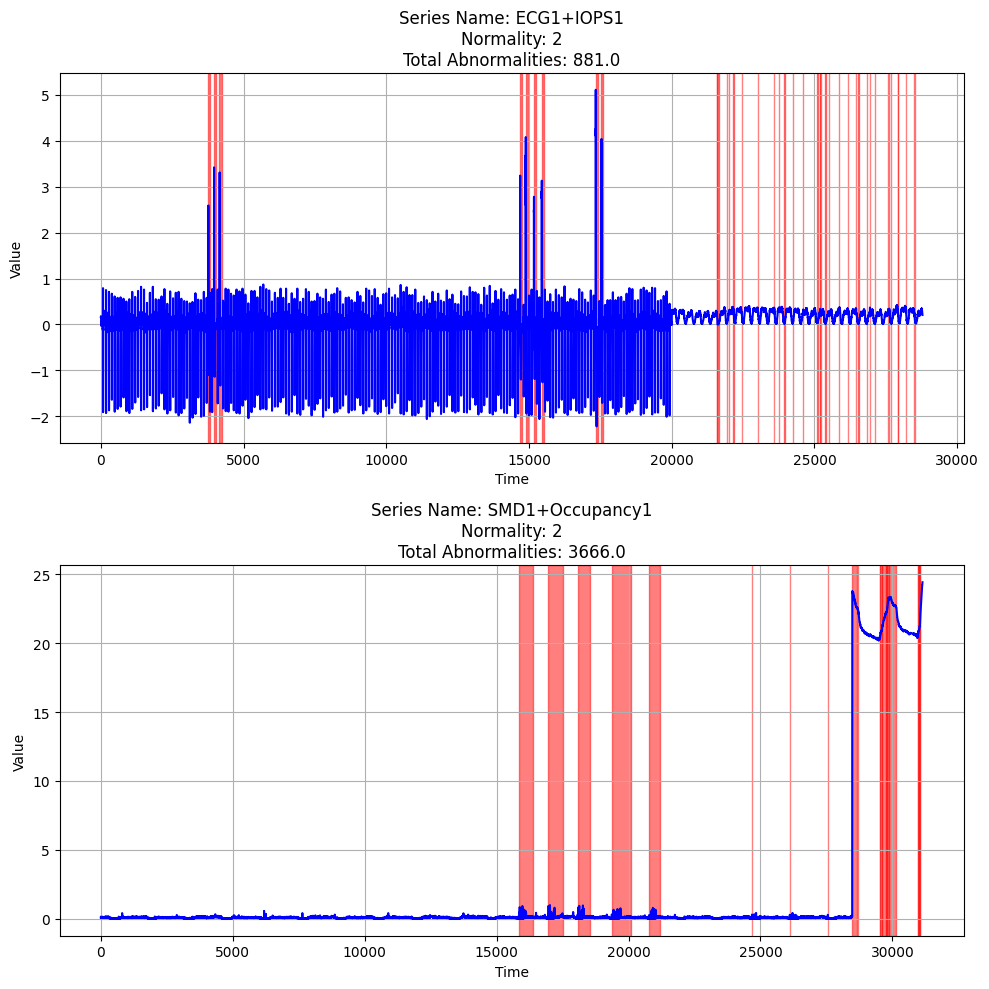

In [30]:
# Call the function to plot the data
plot_time_series_subplots(double_normality_eval)

100%|██████████| 2/2 [00:00<00:00, 20.68it/s]


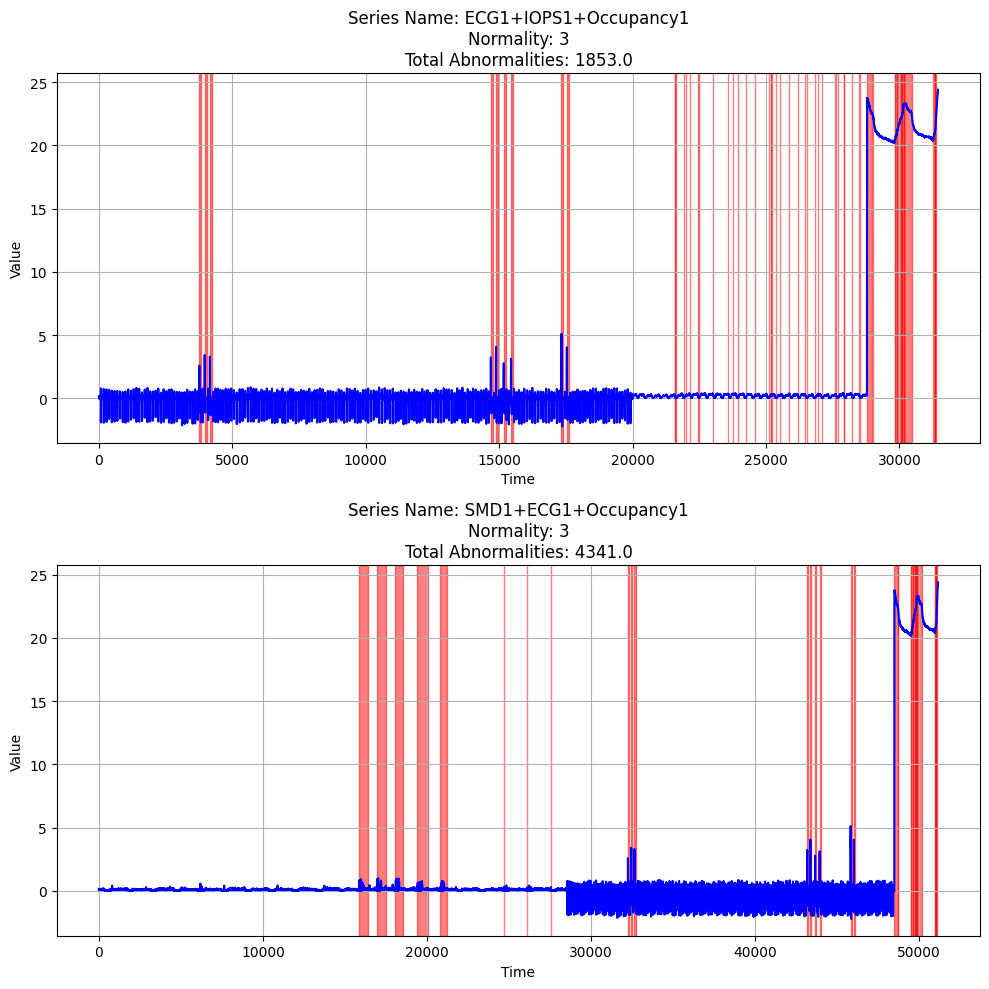

In [31]:
# Call the function to plot the data
plot_time_series_subplots(triple_normality_eval)

100%|██████████| 1/1 [00:00<00:00, 13.96it/s]


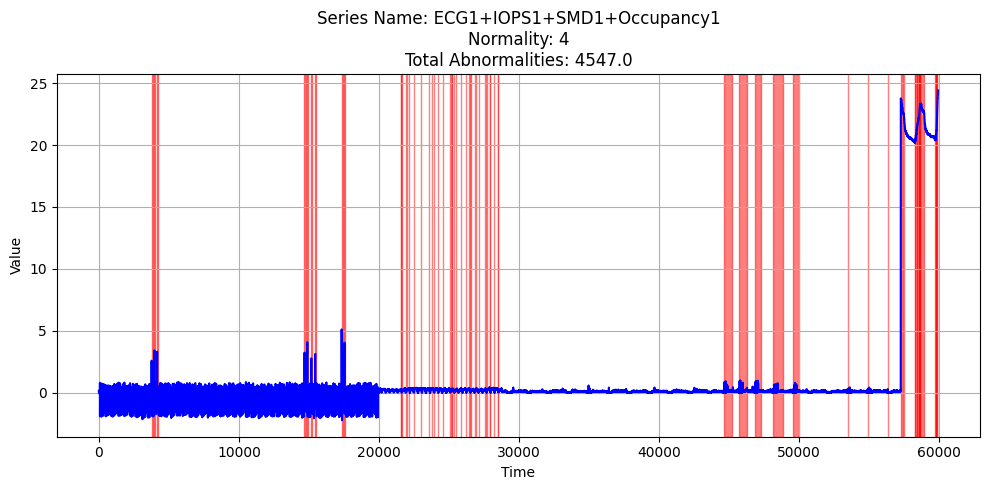

In [32]:
# Call the function to plot the data
plot_time_series_subplots(quadruple_normality_eval)

100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


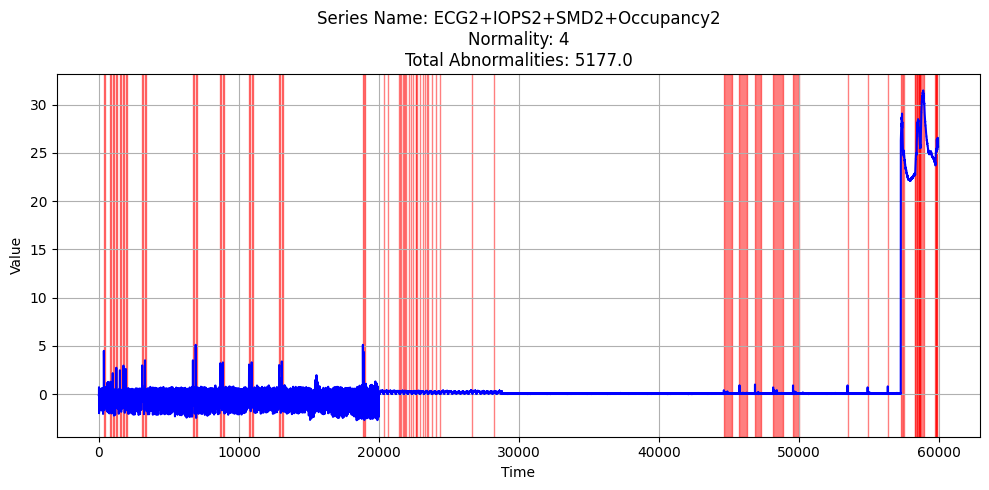

In [33]:
# Call the function to plot the data
plot_time_series_subplots(quadruple_normality_tune)